# AI-text-detector

Improve with following link:
* https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb#scrollTo=eXNLu_-nIrJI

In [75]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, XLMRobertaXLModel
import torch
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from tqdm import tqdm
import torch.optim as optim
import os
import pandas as pd


## Training

In [76]:
# load texts and labels
def text_edit(text):
    # remove first two lines
    text = '\n'.join(text.split('\n')[2:])
    return text

def load_data():

    # load our data
    data = {}

    data_sources = ['data/heste-nettet-nyheder/',
                   'data/from_big_data_file/',
                   'data/heste-nettet-nyheder-ai/gpt-3.5-turbo/', 
                    'data/heste-nettet-nyheder-ai/gpt-4-0613/', 
                    'data/from_big_data_file_ai/gpt-3.5-turbo/', 
                    'data/from_big_data_file_ai/gpt-3.5-turbo-0613/']
    counter = 0
    for path in data_sources:
        for filename in os.listdir(path):
            with open(path + filename, 'r', encoding='utf-8') as f:
                text = text_edit(f.read())
                data[counter] = {'text': text, 'source': path}
                counter += 1

    df = pd.DataFrame.from_dict(data, orient='index')
    df['ai_generated'] = df['source'].str.contains('ai')
    df['ai_generated'] = df['ai_generated'].astype(int)     

    df['val_data'] = 0

    # load validation data
    df_val = pd.read_csv('data/val.csv', index_col=0)
    # strings_val = df_val['0'].tolist()
    df_val['source'] = 'data/val.csv'
    df_val.rename(columns={'0': 'text'}, inplace=True)
    
    # label AI generated
    df_val['ai_generated'] = -1 # dont know
    df_val['val_data'] = 1


    # combine dataframes
    df = pd.concat([df, df_val], axis=0)
    # reset index
    df.reset_index(inplace=True, drop=True)

    return df

def selector(df):
    val_data = df[df['val_data'] == 1]
    val_labels = val_data['val_data'].tolist()
    val_texts = val_data['text'].tolist()

    train_data = df[df['val_data'] == 0]
    # shuffle
    train_data = train_data.sample(frac=1).reset_index(drop=True)
    extra_data = train_data[len(val_data):]
    train_data = train_data[:len(val_data)]
    
    train_labels = train_data['val_data'].tolist()
    train_texts = train_data['text'].tolist()

    texts = train_texts + val_texts
    labels = train_labels + val_labels

    return texts, labels, extra_data

def preprocess(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    return inputs

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.inputs = preprocess(texts)

        # dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
        self.input_ids = self.inputs['input_ids']
        self.attention_mask = self.inputs['attention_mask']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]

        return {
            # 'text': text,
            'label': label,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }


# Assume you're using a GPU for training
device = torch.device("mps" if torch.has_mps else "cpu")
print("Using device:", device)

###### SELECT MODEL ######
model_name = "bert-base-multilingual-cased"  # or another model suitable for Danish
tokenizer = BertTokenizer.from_pretrained(model_name, use_fast=True )
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

df = load_data()
texts, labels, extra_data = selector(df)

texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2)

dataset_train = TextDataset(texts_train, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)

dataset_test = TextDataset(texts_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=True)


# print table summary with total samples in each dataset, positive samples, and negative samples
def pretty_print_info_table(labels_train, labels_test):
    data_for_table = {
        'train': {
            'total': len(labels_train),
            'pos': np.sum(labels_train),
            'neg': len(labels_train) - np.sum(labels_train)
        },
        'test': {
            'total': len(labels_test),
            'pos': np.sum(labels_test),
            'neg': len(labels_test) - np.sum(labels_test)
        }
    }
    data_for_table['total'] = {
        'total': data_for_table['train']['total'] + data_for_table['test']['total'],
        'pos': data_for_table['train']['pos'] + data_for_table['test']['pos'],
        'neg': data_for_table['train']['neg'] + data_for_table['test']['neg']
    }

    print("""
    Info table:
    +----------------+---------+---------+-------+
    |                | Training| Testing | Total
    +----------------+---------+---------+-------+
    | Total samples  | {:7d} | {:7d} | {:7d} |
    | Pos. samples   | {:7d} | {:7d} | {:7d} |  (AI generated)
    | Neg. samples   | {:7d} | {:7d} | {:7d} |  (Human written)
    """.format(
        data_for_table['train']['total'],
        data_for_table['test']['total'],
        data_for_table['total']['total'],
        data_for_table['train']['pos'],
        data_for_table['test']['pos'],
        data_for_table['total']['pos'],
        data_for_table['train']['neg'],
        data_for_table['test']['neg'],
        data_for_table['total']['neg'],
        
        ))

pretty_print_info_table(labels_train, labels_test)

Using device: mps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



    Info table:
    +----------------+---------+---------+-------+
    |                | Training| Testing | Total
    +----------------+---------+---------+-------+
    | Total samples  |    1812 |     454 |    2266 |
    | Pos. samples   |     904 |     229 |    1133 |  (AI generated)
    | Neg. samples   |     908 |     225 |    1133 |  (Human written)
    


In [77]:

model.to(device)

# freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


# Training loop
from transformers import AdamW
lr = 1e-3*.4
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, )

# early stopping
def early_stopping(losses, patience=10):
    if len(losses) < patience:
        return False
    return losses[-1] > max(losses[-patience:-1])

losses = {'train': [], 'test': []}
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    # Train
    loss_total_train = 0
    for i, batch in enumerate(dataloader_train):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)


        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        #rint(outputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        loss_total_train += loss.item()

    print(f"Epoch {epoch} loss: {loss_total_train / len(dataset_train)}")
    losses['train'].append(loss_total_train / len(dataset_train))

    # Test
    model.eval()
    loss_total_test = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader_test):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss_total_test += loss.item()

    print(f"Epoch {epoch} test loss: {loss_total_test / len(dataset_test)}")
    losses['test'].append(loss_total_test / len(dataset_test))

    # if validation loss is lowest, save model
    if min(losses['test']) == losses['test'][-1]:
        model.save_pretrained("models/bert_article_classifier", save_function=torch.save)
        print("Model saved")

    if early_stopping(losses['test']):
        print("Early stopping")
        break


Epoch 0 loss: 0.041072615000849
Epoch 0 test loss: 0.03779978334641142
Model saved
Epoch 1 loss: 0.036611946969895434
Epoch 1 test loss: 0.03373528951327706
Model saved
Epoch 2 loss: 0.03353070658497989
Epoch 2 test loss: 0.030643364800230524
Model saved
Epoch 3 loss: 0.03117836301295173
Epoch 3 test loss: 0.02804419280148813
Model saved
Epoch 4 loss: 0.02930917219149882
Epoch 4 test loss: 0.02616822732702751
Model saved
Epoch 5 loss: 0.027212834713474805
Epoch 5 test loss: 0.024245253940510855
Model saved
Epoch 6 loss: 0.02603132382166833
Epoch 6 test loss: 0.023236127020503983
Model saved
Epoch 7 loss: 0.025245975365833468
Epoch 7 test loss: 0.021712894744284877
Model saved
Epoch 8 loss: 0.024945243337822803
Epoch 8 test loss: 0.0213193090279722
Model saved
Epoch 9 loss: 0.023489185598643936
Epoch 9 test loss: 0.02003815297513281
Model saved
Epoch 10 loss: 0.023320061448657222
Epoch 10 test loss: 0.019721441364760967
Model saved
Epoch 11 loss: 0.022814323809038986
Epoch 11 test loss:

Text(0, 0.5, 'Loss')

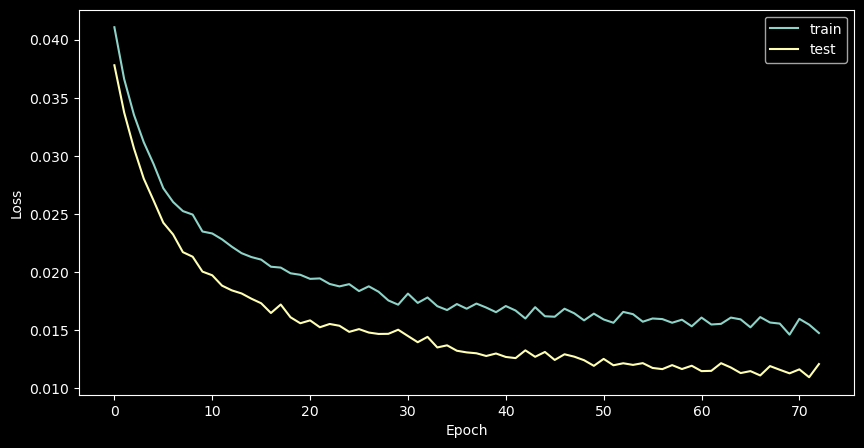

In [78]:
# load model
model = BertForSequenceClassification.from_pretrained("models/bert_article_classifier")
plt.style.use('dark_background')
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses['train'], label='train')
plt.plot(losses['test'], label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

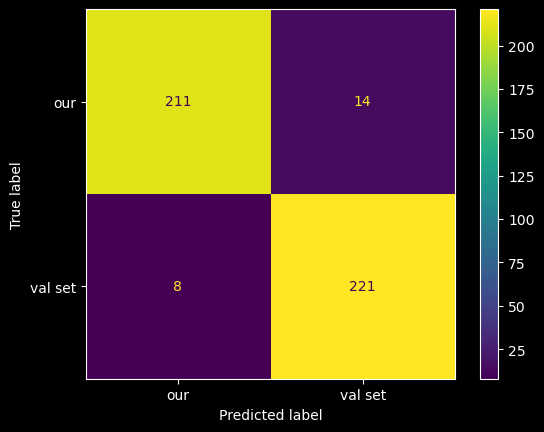

In [93]:
# validation via confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for i, batch in enumerate(dataloader_test):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        y_pred.extend(torch.argmax(logits, dim=1).tolist())
        y_true.extend(labels.tolist())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['our', 'val set'])
disp.plot()

## Model Application

In [79]:
# load my model
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("models/bert_article_classifier")
model.to(device);

100%|██████████| 180/180 [07:29<00:00,  2.50s/it]


Text(0.5, 1.0, 'Confidence of prediction, positive is similar to validation data')

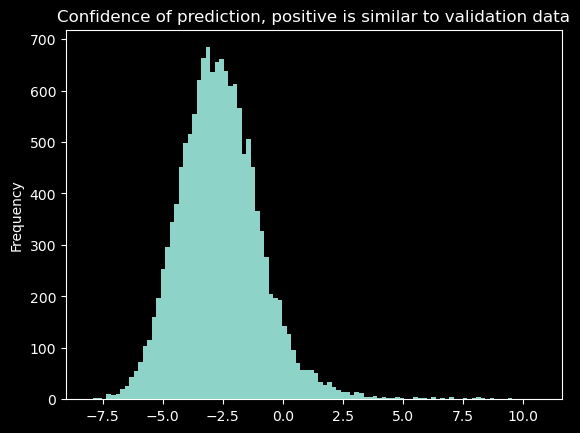

In [80]:
# predict strings_extras
texts_extra = extra_data['text'].tolist()
labels_extra = extra_data['ai_generated'].tolist()
from tqdm import tqdm
N = len(texts_extra)
dataset_apply = TextDataset(texts_extra[:N], labels_extra[:N])
dataloader_apply = DataLoader(dataset_apply, batch_size=80, shuffle=False)

# predict
model.eval()
predictions = []
with torch.no_grad():
    for i, batch in tqdm(enumerate(dataloader_apply), total=len(dataloader_apply)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = logits.cpu().numpy()
        predictions.append(pred)

predictions = np.concatenate(predictions, axis=0)
# put predictions in dataframe along with the strings
df_conf = pd.DataFrame({'text': texts_extra[:N], 
                        'ai_generated': labels_extra[:N],
                        'source': extra_data['source'].tolist()[:N],
                        'ours' : predictions[:, 0], 
                        'val': predictions[:, 1]})
df_conf['most confident'] = df_conf[['ours', 'val']].idxmax(axis=1)
df_conf['confidence'] =  df_conf['val'] - df_conf['ours']
df_conf['confidence'].plot.hist(bins=100)
plt.title("Confidence of prediction, positive is similar to validation data")

In [81]:
# show low confidence predictions and high confidence predictions
n = 3
print(f'The following {n} strings is very not similar to the validation data:')

for i in range(n):
    print(i+1)
    print(df_conf.sort_values('confidence').head(n)['text'].values[i])
    print()

print('#############################')
print(f'The following {n} string is very similar to the validation data:')
for i in range(n):
    print(i+1)
    print(df_conf.sort_values('confidence').tail(n)['text'].values[i])
    print()

The following 3 strings is very not similar to the validation data:
1
Cathrine Dufour og Atterupgaards Cassidy cementerede søndag, at de er Europas stærkeste ungrytterekvipage i dressur. Ved EM i Bern tog den danske ekvipage søndag EM-guldet i kür, og med gårsdagens EM-sejr i det individuelle program, har vi nu en dobbelt dansk europamester. Nanna Skodorg Merrald blev nr. 7. Sølvet gik til Charlott-Maria Schürmann fra Tyskland, mens bronzen gik til tyske Florine Kienbaum. De danske dressurlandshold og talentarbejdet i dressur er sponsoreret af First Horse Hesteforsikring.   Sejrsgang fra Dufour og Cassidy I suveræn stil tog Cathrine Dufour og Atterupgaards Cassidy for anden dag i træk guld ved EM i dressur for ungryttere. Mesterskabet kom i hus med et kür-program til 84,925 %. Nanna Skodborg Merrald og Millibar leverede også en stærk præstation, og med 73,625 % blev de placeret som nr. 7. Sølvmedaljen gik til Charlott-Maria Schürmann fra Tyskland på Burlington med 79,600 %, mens tyske 

In [82]:
df_conf['ai_generated'].value_counts()

ai_generated
0    8932
1    5466
Name: count, dtype: int64

In [94]:
df_conf['text'].value_counts()

text
Vi benytter cookies til at forbedre brugeroplevelsen.Læs mere om cookies\nAktiviteter\nDet digitale samfund\nSe alle emner\nKøb af bolig\nSådan klager du over dit realkreditinstitut\nDen danske realkreditmodel\nIndsigelse ved brug af betalingskort\nSådan skifter du bank\nSådan klager du over din bank\nSikkerhed på nettet\nSe alle gode råd\nRegnskabs- og nøgletal\nAfkast, risiko og omkostninger\nSådan gik det sidste år                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [87]:
df_conf[df_conf['confidence'] > 0]['ai_generated'].value_counts()

ai_generated
0    528
1    397
Name: count, dtype: int64

In [84]:
df_conf.to_csv('data/df_conf.csv')

In [96]:
# select only unique text
print(len(df_conf))
df_conf_unique = df_conf.drop_duplicates(subset=['text'])
print(len(df_conf_unique))

14398
14393


In [86]:
pd.read_csv('data/df_conf.csv', index_col=0)

,text,ai_generated,source,ours,val,most confident,confidence
0,Dansk Varmblods kåringskommission fældede lørd...,0,data/heste-nettet-nyheder/,3.157006,-3.135451,ours,-6.292458
1,Hotellet tilbyder 145 moderne værelser og suit...,1,data/from_big_data_file_ai/gpt-3.5-turbo-0613/,2.563214,-2.441174,ours,-5.004388
2,Hos Hobby Haven har vi engagerede medarbejdere...,0,data/from_big_data_file/,0.013200,0.365958,val,0.352758
3,"Kære landets borgere,\n\nJeg står i dag foran ...",1,data/from_big_data_file_ai/gpt-3.5-turbo-0613/,0.847833,-0.846252,ours,-1.694084
4,Play'n GO er en førende virksomhed inden for u...,1,data/from_big_data_file_ai/gpt-3.5-turbo/,1.450386,-1.252852,ours,-2.703237
...,...,...,...,...,...,...,...
14393,Kære alle\n\nI dag vil jeg gerne tale om noget...,1,data/from_big_data_file_ai/gpt-3.5-turbo-0613/,0.707870,-0.721882,ours,-1.429752
14394,Denne årlige rapport fra DR Medieforskning giv...,1,data/from_big_data_file_ai/gpt-3.5-turbo-0613/,0.973604,-0.908728,ours,-1.882332
14395,En Clicker Tally Counter er en applikation til...,1,data/from_big_data_file_ai/gpt-3.5-turbo-0613/,1.349497,-1.498334,ours,-2.847830
14396,Øget transparens i dressurbedømmelser har skær...,0,data/heste-nettet-nyheder/,1.791122,-1.583158,ours,-3.374280


In [91]:
df_conf[df_conf['confidence'] > 0]['source'].value_counts()

source
data/from_big_data_file/                          495
data/from_big_data_file_ai/gpt-3.5-turbo-0613/    327
data/from_big_data_file_ai/gpt-3.5-turbo/          48
data/heste-nettet-nyheder/                         33
data/heste-nettet-nyheder-ai/gpt-3.5-turbo/        22
Name: count, dtype: int64